In [1]:
from qiskit import QuantumCircuit,QuantumRegister,ClassicalRegister
from qiskit import Aer,IBMQ
from qiskit import execute
from qiskit.tools import visualization
from qiskit.tools.visualization import circuit_drawer, plot_histogram
from qiskit.extensions.quantum_initializer import initializer
import matplotlib.pyplot as plt
from executeCircuit import execute_locally,extractClassical
import math 
import numpy as np

## Preparing QSamples and joining distributions in qiskit 

Having a state $|\psi_1\rangle = \sum_{i=0}^N \sqrt{p_i} |i\rangle$ and a state $|\psi_2\rangle = \sum_{j=0}^N \sqrt{p_{j}'} |j\rangle$ , the joint state of the total system is described as a tensor product of the two states: <br><br>
 $|\psi_1\rangle \otimes |\psi_2\rangle= \sum_{i,j}^N \sqrt{p_i p_{j}'} |i\rangle |j\rangle$ <br><br>
 Sampling the binary string ij from this state is observed with probability $p_i p_{j}'$ , which
is a product of the two original probabilities. In other words, the qsample of two joint
qsamples is a product distribution.

### Initialization

In [2]:
n=2 #distributions represented by 2 qubits


qr = QuantumRegister(n)
qr2 = QuantumRegister(n)
cr = ClassicalRegister(n)
cr2 = ClassicalRegister(n)

qc=QuantumCircuit(qr,qr2,cr,cr2)


### State vector representing the distributions



In [3]:
state=[]
for i in range(2**n):
	if i == 0: 
		state.append(complex(math.sqrt(0.7),0.0))
	elif i == 1:
		state.append(complex(math.sqrt(0.1),0.0))
	elif i == 2:
		state.append(complex(0.0,0.0))
	else:
		state.append(complex(math.sqrt(0.2),0.0))
state2=[]
for i in range(2**n):
	if i == 0: 
		state2.append(complex(math.sqrt(0.8),0.0))
	elif i == 2:
		state2.append(complex(math.sqrt(0.2),0.0))
	else:
		state2.append(complex(0.0,0.0))

### Qiskit Initialize Function 

In [4]:
qc.initialize(state,qr)
qc.initialize(state2,qr2)

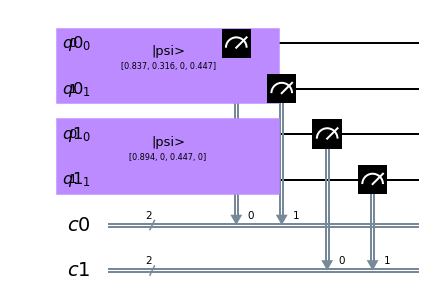

In [5]:
qc.measure(qr,cr)
qc.measure(qr2,cr2)

qc.draw(output="mpl")

### To see the entire circuit we need to decompose the initialize instruction. We need to see the blocks of multiplexes for the gates to uncompute the initialization, and then we need to add a decompose for each multiplex


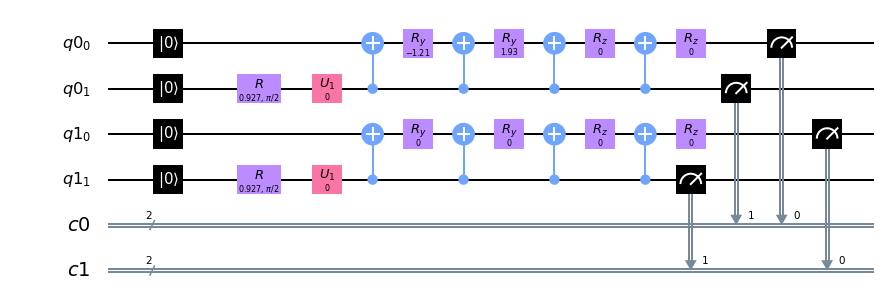

In [6]:
qc_decomposed = qc.decompose().decompose().decompose().decompose()
qc_decomposed.draw(output="mpl")

### execute_locally for default runs the circuit with 1 shot, meaning it takes a sample. 
The most probale state, analysing the state and state2 initialization above will be the |0000> state.

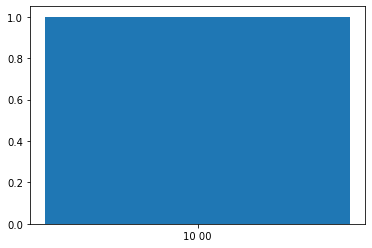

In [6]:
counts,counts_dict = execute_locally(qc,show=True)

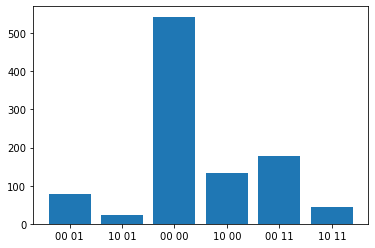

In [7]:
#for 1000 samples
counts,counts_dict = execute_locally(qc,nshots=1000,show=True)


### What about preparing a controlled QSAMPLE?

Suppose that we want to prepare a qsample controlled by 2 quantum regtisters, let's call this operation by the unitary U:<br>
$U : |\psi_1\rangle \otimes |\psi_2\rangle \otimes |0\rangle^{\otimes n_s} = |\psi_1\rangle \otimes |\psi_2\rangle \otimes \sum_{\psi_1 , \psi_2} \sqrt{P_{\psi_1 \psi'}^{\psi_2}} |\psi'\rangle$ <br><br>

#### The Qiskit initialize instruction doesnt have a controlled version, so we need to create one first, i.e, we need to turn every gate in the initialize function source code into a controlled gate, controlled by 1 or n control qubits, dependent of the application

In [8]:
def QSample(statevector,num_qubits):
    sub_qr = QuantumRegister(num_qubits)
    sub_circ = QuantumCircuit(sub_qr,name="QSample")
    sub_circ.initialize(statevector,sub_qr)
    
    # Convert to a gate and stick it into an arbitrary place in the bigger circuit  
    return sub_circ

### Try to append a CRYGate to a quantum state with more than one control qubit

In [2]:
from qiskit.exceptions import QiskitError
from qiskit.circuit import Instruction
from qiskit.extensions.standard.x import XGate, CXGate
from qiskit.extensions.standard.ry import RYGate,CRYGate
from qiskit.extensions.standard.rz import RZGate,CRZGate
from qiskit.circuit.reset import Reset
from math import pi
from qiskit.extensions.standard import multi_control_toffoli_gate
from qiskit.tools import visualization
from qiskit.tools.visualization import circuit_drawer, plot_histogram
import matplotlib.pyplot as plt 

n=2

psi1 = QuantumRegister(n,"psi1")
psi2 = QuantumRegister(1,"psi2")
cr = ClassicalRegister(n)
cr2 = ClassicalRegister(n)

qc=QuantumCircuit(psi1,psi2,cr,cr2)

cry_gate = RYGate(pi).control(num_ctrl_qubits=n,ctrl_state="10") 
qc.append(cry_gate,[i for i in psi1]+[i for i in psi2])
qc.draw()
#qc.decompose().decompose().decompose().decompose().draw(output="mpl")

/home/andre/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: The multi_control_toffoli_gate module is deprecated as of 0.13.0 and will be removed no earlier than 3 months after this release date. The multi-controlled Toffoli and the ``mct`` function can be found in x.py along with the X gates.
  


psi1_0: ────o─────
            │     
psi1_1: ────■─────
        ┌───┴────┐
psi2_0: ┤ Ry(pi) ├
        └────────┘
  c0_0: ══════════
                  
  c0_1: ══════════
                  
  c1_0: ══════════
                  
  c1_1: ══════════

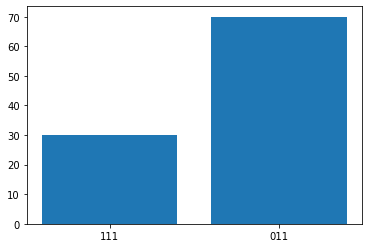

In [10]:
from qAlgorithms import ctrl_initialize

n=2

psi1 = QuantumRegister(n,"psi1")
psi2 = QuantumRegister(1,"psi2")

qc=QuantumCircuit(psi1,psi2)

state=[complex(math.sqrt(0.7),0.0),complex(math.sqrt(0.3),0.0)]

qc.x(psi1)
qc.ctrl_initialize(statevector=state,ctrl_state="11",ctrl_qubits=psi1,qubits=psi2)

#qc.decompose().decompose().decompose().decompose().draw(output="mpl")

qc.measure_all()

r,rc = execute_locally(qc,nshots=100,show=True)

### Test for the case where are more than 2 registers (ctrl,target registers) in the quantum circuit. 

In [3]:
from qiskit.exceptions import QiskitError
from qiskit.circuit import Instruction
from qiskit.extensions.standard.x import XGate, CXGate
from qiskit.extensions.standard.ry import RYGate,CRYGate
from qiskit.extensions.standard.rz import RZGate,CRZGate
from qiskit.circuit.reset import Reset
from math import pi
#from qiskit.extensions.standard import multi_control_toffoli_gate
from qiskit.tools import visualization
from qiskit.tools.visualization import circuit_drawer, plot_histogram
import matplotlib.pyplot as plt 
from qAlgorithms import ctrl_initialize

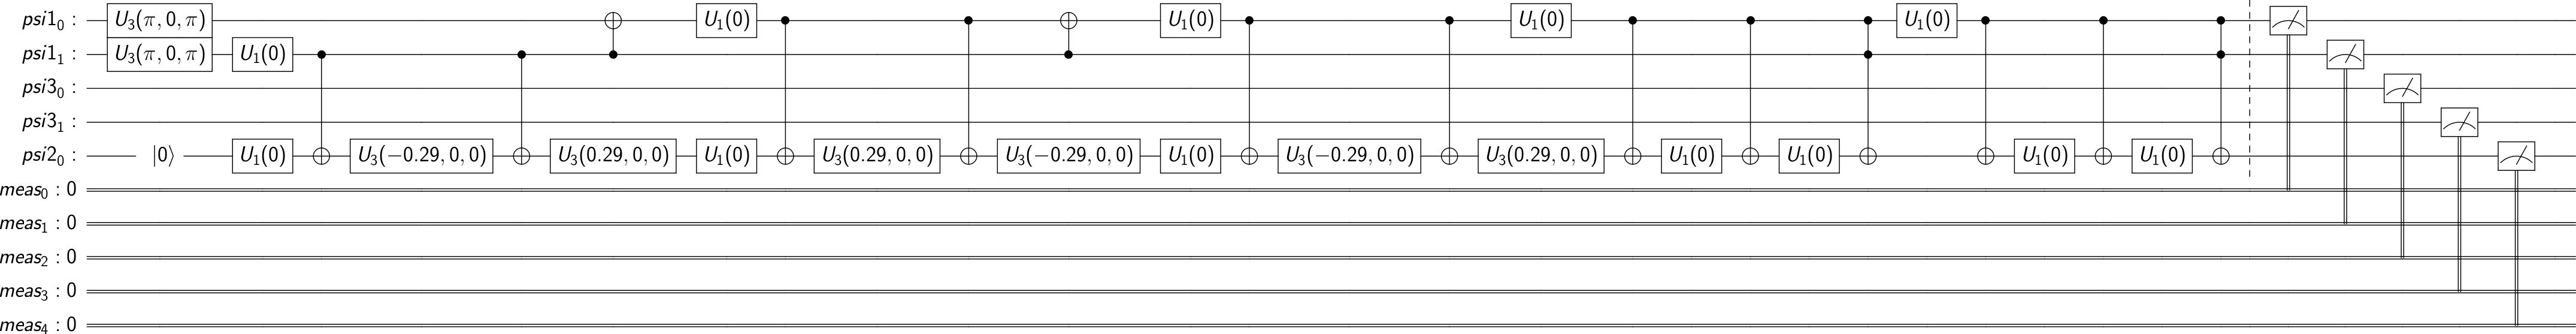

In [4]:
n=2

psi1 = QuantumRegister(n,"psi1")
psi3 = QuantumRegister(n,"psi3")
psi2 = QuantumRegister(1,"psi2")


qc=QuantumCircuit(psi1,psi3,psi2)

state=[complex(math.sqrt(0.7),0.0),complex(math.sqrt(0.3),0.0)]

qc.x(psi1)
qc.ctrl_initialize(statevector=state,ctrl_state="11",ctrl_qubits=psi1,qubits=psi2)
qc.measure_all()

#Save decomposition as a figure for latex embedding
qc.decompose().decompose().decompose().decompose().draw(output="latex",filename="ctrl_init.png")
#qc.draw(output="latex")


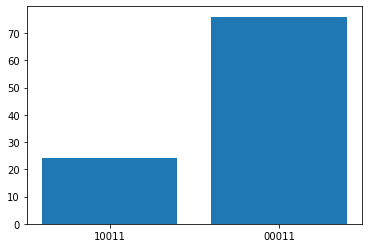

In [5]:
r,rc = execute_locally(qc,nshots=100,show=True)

### Test for the case that we have more than one quantum register as control registers.
### For this to work , i had to change the source code of ~/anaconda3/lib/python3.7/site-packages/qiskit/circuit/add_control.py to enable mct gate with mode="advanced" in order to deal with the fact that IBM doesnt have coded quantum ancillas for the decomposition of the mct gate

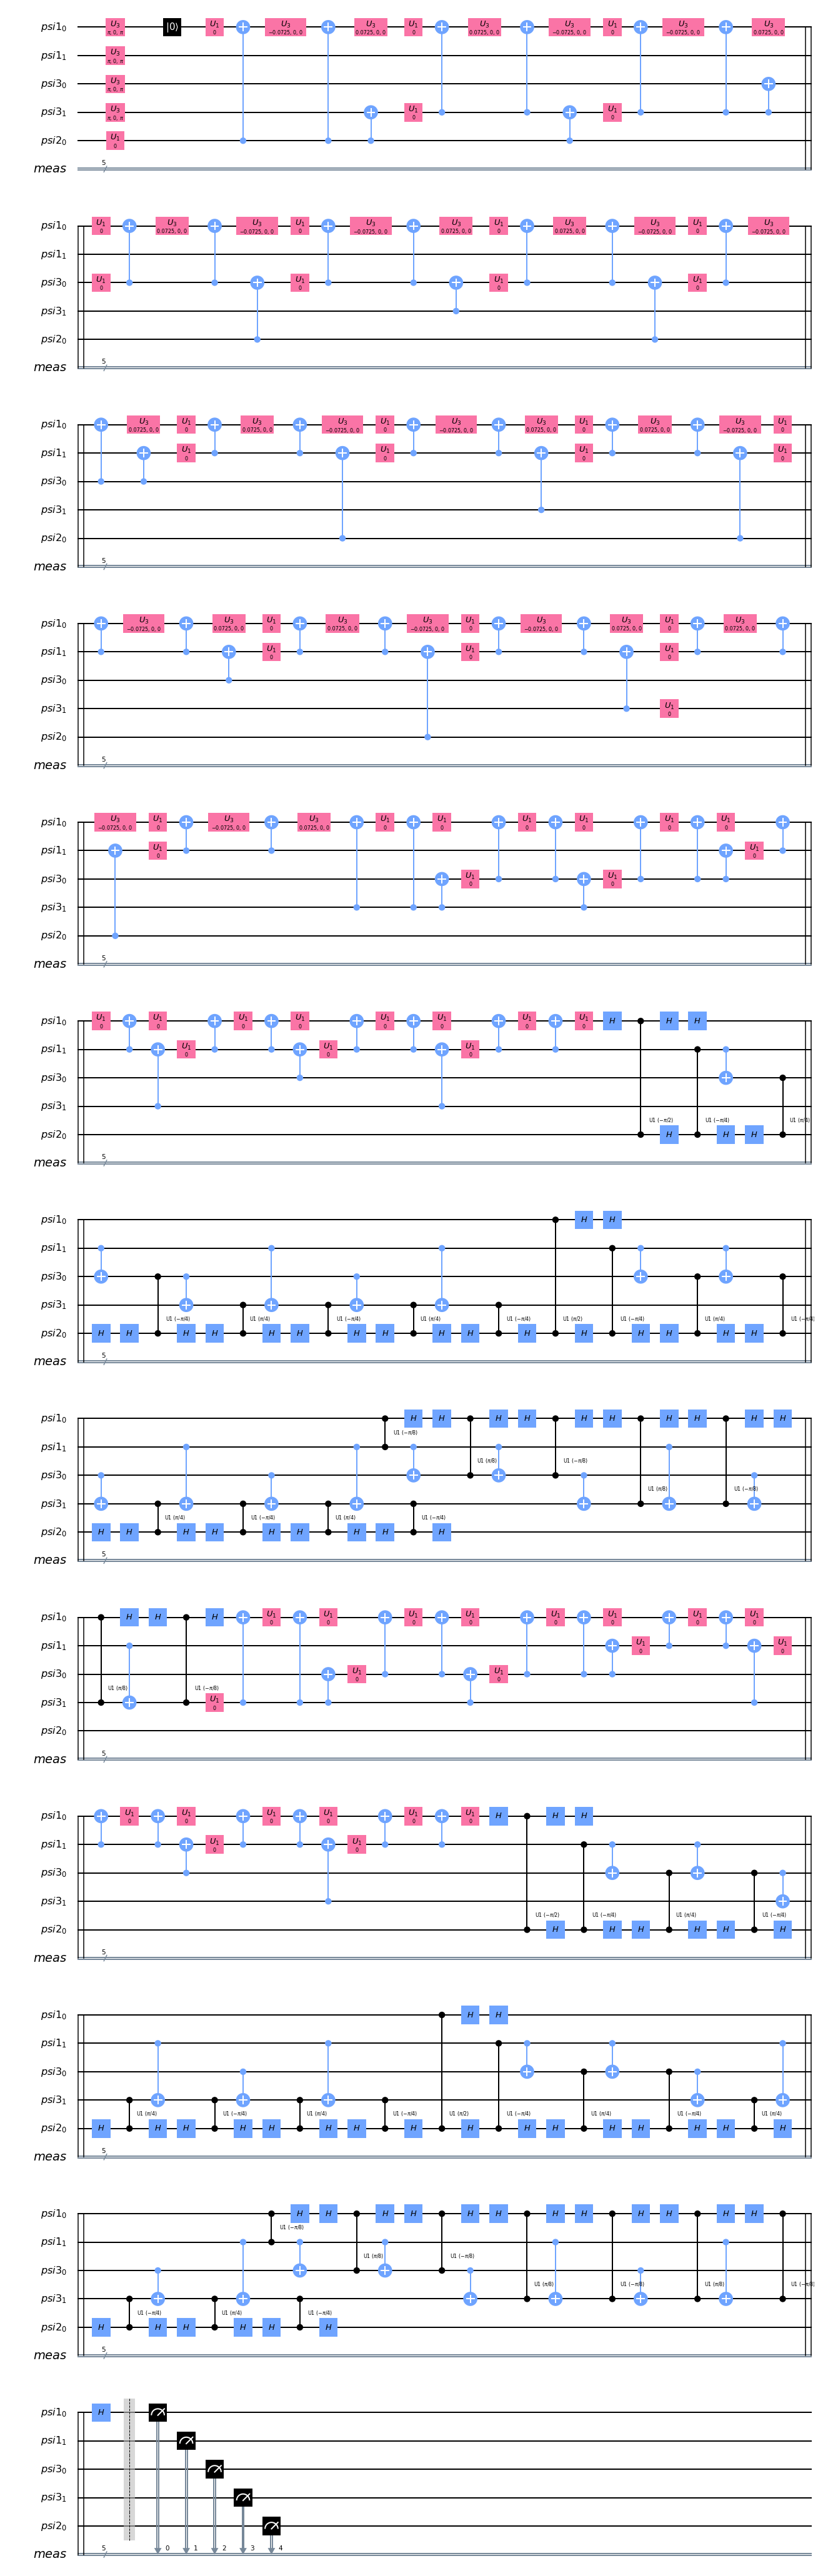

In [10]:
n=2

psi1 = QuantumRegister(n,"psi1")
psi3 = QuantumRegister(n,"psi3")
psi2 = QuantumRegister(1,"psi2")


qc=QuantumCircuit(psi1,psi3,psi2)

state=[complex(math.sqrt(0.7),0.0),complex(math.sqrt(0.3),0.0)]
ctrls=[i for i in psi1]+[i for i in psi3]

qc.x(psi1)
qc.x(psi3)
qc.ctrl_initialize(statevector=state,ctrl_state="1111",ctrl_qubits=ctrls,qubits=psi2)
qc.measure_all()

#Save decomposition as a figure for latex embedding
#qc.decompose().decompose().decompose().decompose().draw(output="latex",filename="ctrl_init.png")
qc.decompose().decompose().decompose().decompose().draw(output="mpl")
#qc.draw(output="mpl")


In [39]:
def new_state():
    qr = QuantumRegister(3)
    qr2 = QuantumRegister(1)
    qc = QuantumCircuit(qr,qr2)
    qc.x(qr)
    qc.cx(qr[0],qr2[0])
    return qc

regs = [QuantumRegister(3) for i in range(5)]
regs2 = QuantumRegister(1)
c=QuantumCircuit()
for i in range(5):
    c.add_register(regs[i])
c.add_register(regs2)

new_c = new_state()
for i in range(5):
    regis = [i for i in regs[i]]+[i for i in regs2]
    c.append(new_c,regis)

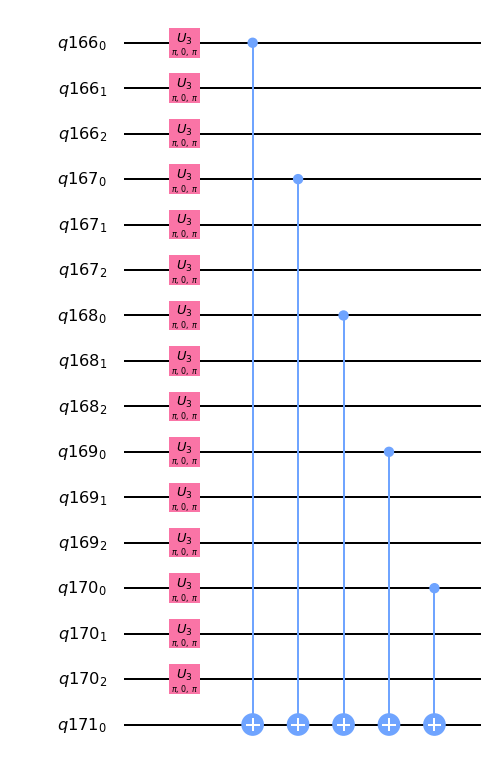

In [40]:
c.decompose().decompose().decompose().decompose().draw(output="mpl")

### prepare state